## Imports

In [12]:
import pickle
import string
import sys
import tempfile
from pathlib import Path

import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import torch
import torch.nn as nn
import torch.optim as optim
from scipy import stats
from torch.utils.data import DataLoader, Dataset

In [13]:
pd.set_option("max_columns", 10000)
pd.set_option("max_rows", 10000)

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameters

In [15]:
NOTEBOOK_PATH = Path("prepare_training_data_3c").resolve()
NOTEBOOK_PATH.mkdir(exist_ok=True)
NOTEBOOK_PATH

PosixPath('/home/kimlab1/strokach/workspace/2019-xtx-forecasting-challenge/notebooks/prepare_training_data_3c')

## Functions

In [16]:
%%file {NOTEBOOK_PATH}/utils.py
import numpy as np


def fillna_with_carryover(df, op):
    return np.where(df.isnull(), np.repeat(op(df, axis=1)[:, None], 15, 1), df)


def compute_time_delta(df):
    empty_row = np.zeros((1, df.shape[1]))
    df_out = np.vstack([empty_row, (df.values[1:, :] - df.values[:-1, :])])
    df_out = np.hstack([df_out[:, :1], df_out[:, 1:] - df_out[:, :-1]])
    return df_out


def fix_input_df(df, max_size=6.513230110912307):
    ask_rate_cols = [c for c in df.columns if c.startswith("askRate")]
    bid_rate_cols = [c for c in df.columns if c.startswith("bidRate")]
    ask_size_cols = [c for c in df.columns if c.startswith("askSize")]
    bid_size_cols = [c for c in df.columns if c.startswith("bidSize")]

    # Fill in missing rates with max / min rates
    df[ask_rate_cols] = fillna_with_carryover(df[ask_rate_cols], np.max)
    df[bid_rate_cols] = fillna_with_carryover(df[bid_rate_cols], np.min)

    # Fill in missing sizes with 1
    df[ask_size_cols] = df[ask_size_cols].fillna(1)
    df[bid_size_cols] = df[bid_size_cols].fillna(1)

    # Normalize size columns
    df[ask_size_cols + bid_size_cols] = np.log(df[ask_size_cols + bid_size_cols].values)
    max_size = max_size or df[ask_size_cols + bid_size_cols].values.max()
    df[ask_size_cols + bid_size_cols] = df[ask_size_cols + bid_size_cols].values / max_size

    # Compute time deltas
    for col_name, col_data in zip([c + "_tdelta" for c in ask_rate_cols], compute_time_delta(df[ask_rate_cols]).T):
        df[col_name] = col_data
    for col_name, col_data in zip([c + "_tdelta" for c in bid_rate_cols], compute_time_delta(df[bid_rate_cols]).T):
        df[col_name] = col_data

    # Compute ab deltas
    for col_name, col_data in zip(
        [c + "_abdelta" for c in ask_size_cols], (df[ask_size_cols].values - df[bid_size_cols].values).T
    ):
        df[col_name] = col_data

    return df, max_size

Overwriting /home/kimlab1/strokach/workspace/2019-xtx-forecasting-challenge/notebooks/prepare_training_data_3c/utils.py


In [17]:
%run {NOTEBOOK_PATH}/utils.py

### Load data

In [18]:
data_training = pd.read_csv("../data/data-training.csv.gz")

In [19]:
display(data_training.head(2))
print(len(data_training))

askRate0  askRate1  askRate2  askRate3  askRate4  askRate5  askRate6  \
0    1619.5    1620.0    1621.0       NaN       NaN       NaN       NaN   
1    1619.5    1620.0    1621.0    1621.5       NaN       NaN       NaN   

   askRate7  askRate8  askRate9  askRate10  askRate11  askRate12  askRate13  \
0       NaN       NaN       NaN        NaN        NaN        NaN        NaN   
1       NaN       NaN       NaN        NaN        NaN        NaN        NaN   

   askRate14  askSize0  askSize1  askSize2  askSize3  askSize4  askSize5  \
0        NaN       1.0      10.0      24.0       NaN       NaN       NaN   
1        NaN       1.0      10.0      24.0       5.0       NaN       NaN   

   askSize6  askSize7  askSize8  askSize9  askSize10  askSize11  askSize12  \
0       NaN       NaN       NaN       NaN        NaN        NaN        NaN   
1       NaN       NaN       NaN       NaN        NaN        NaN        NaN   

   askSize13  askSize14  bidRate0  bidRate1  bidRate2  bidRate3  bidRate4  \
0        NaN        NaN    1615.0    1614.0    1613.0    1612.0    1611.0   
1        NaN        NaN    1615.0    1614.0    1613.0    1612.0    1611.0   

   bidRate5  bidRate6  bidRate7  bidRate8  bidRate9  bidRate10  bidRate11  \
0    1610.0    1607.0    1606.0    1605.0    1604.0     1603.0     1602.0   
1    1610.0    1607.0    1606.0    1605.0    1604.0     1603.0     1602.0   

   bidRate12  bidRate13  bidRate14  bidSize0  bidSize1  bidSize2  bidSize3  \
0     1601.5     1601.0     1600.0       7.0      10.0       1.0      10.0   
1     1601.5     1601.0     1600.0       7.0      10.0       1.0      10.0   

   bidSize4  bidSize5  bidSize6  bidSize7  bidSize8  bidSize9  bidSize10  \
0      20.0       3.0      20.0      27.0      11.0      14.0       35.0   
1      20.0       3.0      20.0      27.0      11.0      14.0       35.0   

   bidSize11  bidSize12  bidSize13  bidSize14    y  
0       10.0        1.0       10.0       13.0 -0.5  
1       10.0        1.0       10.0       13.0 -0.5

2999999


In [20]:
# data_training.tail(10000).drop("y", axis=1).to_csv("../XTXStarterKit/python/starter-data.csv", sep=",", index=False, header=False)

In [21]:
# data_training.tail(10000).to_csv("../XTXStarterKit/python/starter-data.csv", sep=",", index=False)

In [22]:
data_training_fixed, _ = fix_input_df(data_training.copy())

In [23]:
for i in range(5):
    print(i)
    start = int(len(data_training_fixed) * 0.2 * i)
    stop = int(len(data_training_fixed) * 0.2 * (i + 1))

    train_df = pd.concat([data_training_fixed.iloc[:start], data_training_fixed.iloc[stop:]]).copy()
    valid_df = data_training_fixed.iloc[start:stop].copy()
    assert len(train_df) + len(valid_df) == len(data_training_fixed)
    assert not set(train_df.index) & set(valid_df.index)

#     pq.write_table(
#         pa.Table.from_pandas(train_df, preserve_index=False),
#         NOTEBOOK_PATH.joinpath(f"train_{i}.parquet"),
#     )
#     pq.write_table(
#         pa.Table.from_pandas(valid_df, preserve_index=False),
#         NOTEBOOK_PATH.joinpath(f"valid_{i}.parquet"),
#     )

0
1
2
3
4


### Display statistics

In [24]:
display(train_df.head(2))
print(len(train_df))

askRate0  askRate1  askRate2  askRate3  askRate4  askRate5  askRate6  \
0    1619.5    1620.0    1621.0    1621.0    1621.0    1621.0    1621.0   
1    1619.5    1620.0    1621.0    1621.5    1621.5    1621.5    1621.5   

   askRate7  askRate8  askRate9  askRate10  askRate11  askRate12  askRate13  \
0    1621.0    1621.0    1621.0     1621.0     1621.0     1621.0     1621.0   
1    1621.5    1621.5    1621.5     1621.5     1621.5     1621.5     1621.5   

   askRate14  askSize0  askSize1  askSize2  askSize3  askSize4  askSize5  \
0     1621.0       0.0  0.353524  0.487938  0.000000       0.0       0.0   
1     1621.5       0.0  0.353524  0.487938  0.247103       0.0       0.0   

   askSize6  askSize7  askSize8  askSize9  askSize10  askSize11  askSize12  \
0       0.0       0.0       0.0       0.0        0.0        0.0        0.0   
1       0.0       0.0       0.0       0.0        0.0        0.0        0.0   

   askSize13  askSize14  bidRate0  bidRate1  bidRate2  bidRate3  bidRate4  \
0        0.0        0.0    1615.0    1614.0    1613.0    1612.0    1611.0   
1        0.0        0.0    1615.0    1614.0    1613.0    1612.0    1611.0   

   bidRate5  bidRate6  bidRate7  bidRate8  bidRate9  bidRate10  bidRate11  \
0    1610.0    1607.0    1606.0    1605.0    1604.0     1603.0     1602.0   
1    1610.0    1607.0    1606.0    1605.0    1604.0     1603.0     1602.0   

   bidRate12  bidRate13  bidRate14  bidSize0  bidSize1  bidSize2  bidSize3  \
0     1601.5     1601.0     1600.0  0.298763  0.353524       0.0  0.353524   
1     1601.5     1601.0     1600.0  0.298763  0.353524       0.0  0.353524   

   bidSize4  bidSize5  bidSize6  bidSize7  bidSize8  bidSize9  bidSize10  \
0  0.459946  0.168674  0.459946  0.506022  0.368158  0.405184   0.545866   
1  0.459946  0.168674  0.459946  0.506022  0.368158  0.405184   0.545866   

   bidSize11  bidSize12  bidSize13  bidSize14    y  askRate0_tdelta  \
0   0.353524        0.0   0.353524   0.393806 -0.5              0.0   
1   0.353524        0.0   0.353524   0.393806 -0.5              0.0   

   askRate1_tdelta  askRate2_tdelta  askRate3_tdelta  askRate4_tdelta  \
0              0.0              0.0              0.0              0.0   
1              0.0              0.0              0.5              0.0   

   askRate5_tdelta  askRate6_tdelta  askRate7_tdelta  askRate8_tdelta  \
0              0.0              0.0              0.0              0.0   
1              0.0              0.0              0.0              0.0   

   askRate9_tdelta  askRate10_tdelta  askRate11_tdelta  askRate12_tdelta  \
0              0.0               0.0               0.0               0.0   
1              0.0               0.0               0.0               0.0   

   askRate13_tdelta  askRate14_tdelta  bidRate0_tdelta  bidRate1_tdelta  \
0               0.0               0.0              0.0              0.0   
1               0.0               0.0              0.0              0.0   

   bidRate2_tdelta  bidRate3_tdelta  bidRate4_tdelta  bidRate5_tdelta  \
0              0.0              0.0              0.0              0.0   
1              0.0              0.0              0.0              0.0   

   bidRate6_tdelta  bidRate7_tdelta  bidRate8_tdelta  bidRate9_tdelta  \
0              0.0              0.0              0.0              0.0   
1              0.0              0.0              0.0              0.0   

   bidRate10_tdelta  bidRate11_tdelta  bidRate12_tdelta  bidRate13_tdelta  \
0               0.0               0.0               0.0               0.0   
1               0.0               0.0               0.0               0.0   

   bidRate14_tdelta  askSize0_abdelta  askSize1_abdelta  askSize2_abdelta  \
0               0.0         -0.298763               0.0          0.487938   
1               0.0         -0.298763               0.0          0.487938   

   askSize3_abdelta  askSize4_abdelta  askSize5_abdelta  askSize6_abdelta  \
0         -0.353524         -0.459946         -0.168674  

2399999


In [25]:
display(valid_df.head(2))
print(len(valid_df))

askRate0  askRate1  askRate2  askRate3  askRate4  askRate5  askRate6  \
2399999    1660.0    1660.5    1661.0    1661.5    1662.0    1662.5    1663.0   
2400000    1660.0    1660.5    1661.0    1661.5    1662.0    1662.5    1663.0   

         askRate7  askRate8  askRate9  askRate10  askRate11  askRate12  \
2399999    1663.5    1664.0    1664.5     1665.0     1665.5     1666.0   
2400000    1663.5    1664.0    1664.5     1665.0     1665.5     1666.0   

         askRate13  askRate14  askSize0  askSize1  askSize2  askSize3  \
2399999     1666.5     1667.0  0.212843  0.368158  0.353524  0.381517   
2400000     1666.5     1667.0  0.212843  0.368158  0.353524  0.381517   

         askSize4  askSize5  askSize6  askSize7  askSize8  askSize9  \
2399999  0.353524  0.319264  0.393806  0.337348  0.319264  0.405184   
2400000  0.353524  0.319264  0.393806  0.337348  0.319264  0.405184   

         askSize10  askSize11  askSize12  askSize13  askSize14  bidRate0  \
2399999   0.319264   0.168674   0.405184        0.0   0.247103    1659.0   
2400000   0.319264   0.168674   0.405184        0.0   0.247103    1659.0   

         bidRate1  bidRate2  bidRate3  bidRate4  bidRate5  bidRate6  bidRate7  \
2399999    1658.5    1658.0    1657.5    1657.0    1656.5    1656.0    1655.5   
2400000    1658.5    1658.0    1657.5    1657.0    1656.5    1656.0    1655.5   

         bidRate8  bidRate9  bidRate10  bidRate11  bidRate12  bidRate13  \
2399999    1655.0    1654.5     1654.0     1653.5     1653.0     1652.5   
2400000    1655.0    1654.5     1654.0     1653.5     1653.0     1652.5   

         bidRate14  bidSize0  bidSize1  bidSize2  bidSize3  bidSize4  \
2399999     1652.0  0.494206  0.405184  0.494206  0.631157  0.506022   
2400000     1652.0  0.511606  0.405184  0.494206  0.631157  0.506022   

         bidSize5  bidSize6  bidSize7  bidSize8  bidSize9  bidSize10  \
2399999  0.415777   0.56248  0.393806  0.685667       0.0   0.319264   
2400000  0.415777   0.56248  0.393806  0.685667       0.0   0.319264   

         bidSize11  bidSize12  bidSize13  bidSize14    y  askRate0_tdelta  \
2399999        0.0    0.79899   0.106421   0.558492  0.0              0.0   
2400000        0.0    0.79899   0.106421   0.558492  0.0              0.0   

         askRate1_tdelta  askRate2_tdelta  askRate3_tdelta  askRate4_tdelta  \
2399999              0.0              0.0              0.0              0.0   
2400000              0.0              0.0              0.0              0.0   

         askRate5_tdelta  askRate6_tdelta  askRate7_tdelta  askRate8_tdelta  \
2399999              0.0              0.0              0.0              0.0   
2400000              0.0              0.0              0.0              0.0   

         askRate9_tdelta  askRate10_tdelta  askRate11_tdelta  \
2399999              0.0               0.0               0.0   
2400000              0.0               0.0               0.0   

         askRate12_tdelta  askRate13_tdelta  askRate14_tdelta  \
2399999               0.0               0.0               0.0   
2400000               0.0               0.0               0.0   

         bidRate0_tdelta  bidRate1_tdelta  bidRate2_tdelta  bidRate3_tdelta  \
2399999             -0.5              0.0              0.0              0.0   
2400000              0.0              0.0              0.0              0.0   

         bidRate4_tdelta  bidRate5_tdelta  bidRate6_tdelta  bidRate7_tdelta  \
2399999              0.0              0.0              0.0              0.0   
2400000              0.0              0.0              0.0              0.0   

         bidRate8_tdelta  bidRate9_tdelta  bidRate10_tdelta  bidRate11_tdelta  \
2399999              0.0              0.0               0.0               0.0   
2400000              0.0              0.0               0.0               0.0   

         bidRate12_tdelta  bidRate13_tdelta  bidRate14_tdelta  \
2399999               0.0               0.0               0.0   
2400000               0.0   

600000


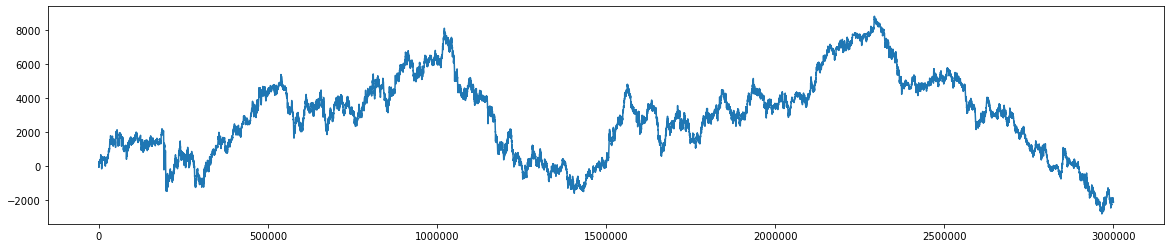

In [28]:
fg, ax = plt.subplots(figsize=(20, 4))
plt.plot(np.cumsum(data_training_fixed["y"].values))

In [17]:
df = train_df

In [18]:
df.columns[df.columns.str.match("askRate\d+$")]

Index(['askRate0', 'askRate1', 'askRate2', 'askRate3', 'askRate4', 'askRate5',
       'askRate6', 'askRate7', 'askRate8', 'askRate9', 'askRate10',
       'askRate11', 'askRate12', 'askRate13', 'askRate14'],
      dtype='object')

#### Rates

In [19]:
rates = np.r_[
    df.loc[:, df.columns.str.match("askRate\d+_tdelta$")].values.reshape(-1),
    df.loc[:, df.columns.str.match("bidRate\d+_tdelta$")].values.reshape(-1),
]

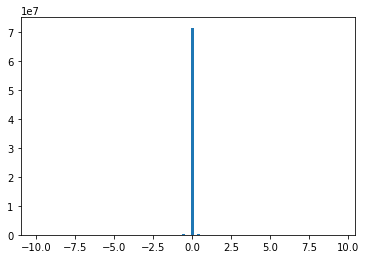

In [20]:
_ = plt.hist(rates, 100)

In [21]:
rates_nz = rates[rates != 0]

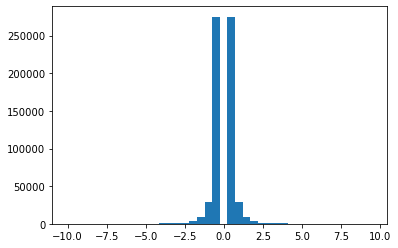

In [22]:
_ = plt.hist(rates_nz, 40)

#### Sizes

In [23]:
sizes = np.r_[
    df.loc[:, df.columns.str.match("askSize\d+$")].values.reshape(-1),
    df.loc[:, df.columns.str.match("bidSize\d+$")].values.reshape(-1),
]

In [24]:
sizes.shape

(71999970,)

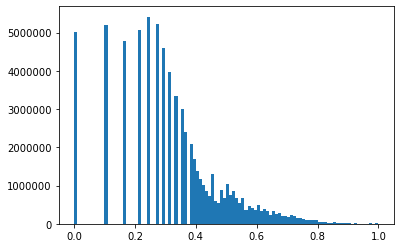

In [25]:
_ = plt.hist(sizes, bins=100)

#### Data

In [26]:
data_training = df.iloc[1:]

In [27]:
display(data_training.head(2))
print(len(data_training))

askRate0  askRate1  askRate2  askRate3  askRate4  askRate5  askRate6  \
1    1619.5    1620.0    1621.0    1621.5    1621.5    1621.5    1621.5   
2    1619.5    1620.0    1621.0    1621.5    1622.0    1622.0    1622.0   

   askRate7  askRate8  askRate9  askRate10  askRate11  askRate12  askRate13  \
1    1621.5    1621.5    1621.5     1621.5     1621.5     1621.5     1621.5   
2    1622.0    1622.0    1622.0     1622.0     1622.0     1622.0     1622.0   

   askRate14  askSize0  askSize1  askSize2  askSize3  askSize4  askSize5  \
1     1621.5       0.0  0.353524  0.487938  0.247103  0.000000       0.0   
2     1622.0       0.0  0.353524  0.487938  0.247103  0.106421       0.0   

   askSize6  askSize7  askSize8  askSize9  askSize10  askSize11  askSize12  \
1       0.0       0.0       0.0       0.0        0.0        0.0        0.0   
2       0.0       0.0       0.0       0.0        0.0        0.0        0.0   

   askSize13  askSize14  bidRate0  bidRate1  bidRate2  bidRate3  bidRate4  \
1        0.0        0.0    1615.0    1614.0    1613.0    1612.0    1611.0   
2        0.0        0.0    1615.0    1614.0    1613.0    1612.0    1611.0   

   bidRate5  bidRate6  bidRate7  bidRate8  bidRate9  bidRate10  bidRate11  \
1    1610.0    1607.0    1606.0    1605.0    1604.0     1603.0     1602.0   
2    1610.0    1607.0    1606.0    1605.0    1604.0     1603.0     1602.0   

   bidRate12  bidRate13  bidRate14  bidSize0  bidSize1  bidSize2  bidSize3  \
1     1601.5     1601.0     1600.0  0.298763  0.353524       0.0  0.353524   
2     1601.5     1601.0     1600.0  0.298763  0.353524       0.0  0.353524   

   bidSize4  bidSize5  bidSize6  bidSize7  bidSize8  bidSize9  bidSize10  \
1  0.459946  0.168674  0.459946  0.506022  0.368158  0.405184   0.545866   
2  0.459946  0.168674  0.459946  0.506022  0.368158  0.405184   0.545866   

   bidSize11  bidSize12  bidSize13  bidSize14    y  askRate0_tdelta  \
1   0.353524        0.0   0.353524   0.393806 -0.5              0.0   
2   0.353524        0.0   0.353524   0.393806 -0.5              0.0   

   askRate1_tdelta  askRate2_tdelta  askRate3_tdelta  askRate4_tdelta  \
1              0.0              0.0              0.5              0.0   
2              0.0              0.0              0.0              0.5   

   askRate5_tdelta  askRate6_tdelta  askRate7_tdelta  askRate8_tdelta  \
1              0.0              0.0              0.0              0.0   
2              0.0              0.0              0.0              0.0   

   askRate9_tdelta  askRate10_tdelta  askRate11_tdelta  askRate12_tdelta  \
1              0.0               0.0               0.0               0.0   
2              0.0               0.0               0.0               0.0   

   askRate13_tdelta  askRate14_tdelta  bidRate0_tdelta  bidRate1_tdelta  \
1               0.0               0.0              0.0              0.0   
2               0.0               0.0              0.0              0.0   

   bidRate2_tdelta  bidRate3_tdelta  bidRate4_tdelta  bidRate5_tdelta  \
1              0.0              0.0              0.0              0.0   
2              0.0              0.0              0.0              0.0   

   bidRate6_tdelta  bidRate7_tdelta  bidRate8_tdelta  bidRate9_tdelta  \
1              0.0              0.0              0.0              0.0   
2              0.0              0.0              0.0              0.0   

   bidRate10_tdelta  bidRate11_tdelta  bidRate12_tdelta  bidRate13_tdelta  \
1               0.0               0.0               0.0               0.0   
2               0.0               0.0               0.0               0.0   

   bidRate14_tdelta  askSize0_abdelta  askSize1_abdelta  askSize2_abdelta  \
1               0.0         -0.298763               0.0          0.487938   
2               0.0         -0.298763               0.0          0.487938   

   askSize3_abdelta  askSize4_abdelta  askSize5_abdelta  askSize6_abdelta  \
1         -0.106421         -0.459946         -0.168674  

2399998


#### Market

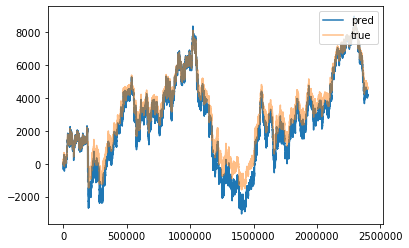

In [28]:
plt.plot(np.cumsum(train_df["askRate0_tdelta"].values * 100), label="pred")
plt.plot(np.cumsum(train_df["y"].values), label="true", alpha=0.5)
plt.legend(loc="upper right")

In [29]:
stats.spearmanr(train_df["y"], train_df["askRate0"] + train_df["bidRate0"])

SpearmanrResult(correlation=-0.013492774076372047, pvalue=4.939384679446786e-97)

In [30]:
stats.spearmanr(train_df["y"], (train_df.loc[:, train_df.columns.str.match("askRate[1-9]+_tdelta")] != 0).sum(axis=1))

SpearmanrResult(correlation=0.012697049398927147, pvalue=3.824490990981303e-86)

In [31]:
stats.spearmanr(train_df["y"], (train_df.loc[:, train_df.columns.str.match("bidRate[1-9]+_tdelta")] != 0).sum(axis=1))

SpearmanrResult(correlation=-0.010119280400233334, pvalue=2.1689498146419842e-55)

#### Features

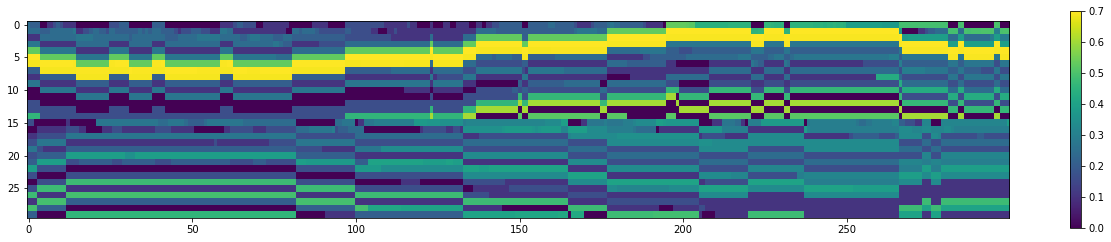

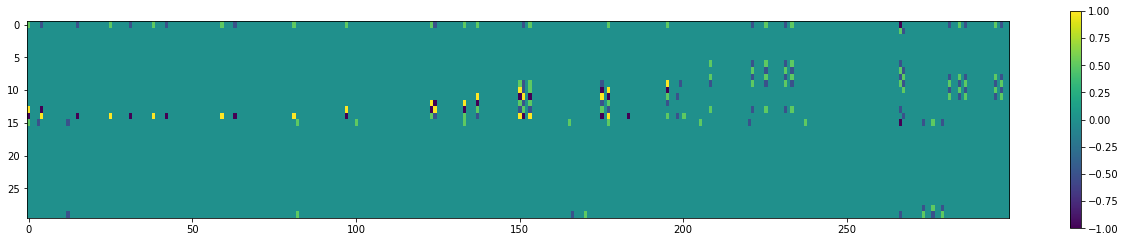

In [32]:
i = 210000

values = df.iloc[
    i:i + 300, df.columns.str.match("...Rate\d+_tdelta$") | df.columns.str.match("...Size\d+$")
].values

fg, ax = plt.subplots(figsize=(22, 4))
plt.imshow(values[:, :30].T, aspect=2)
plt.colorbar()
plt.show()

fg, ax = plt.subplots(figsize=(22, 4))
plt.imshow(values[:, 30:].T, aspect=2)
plt.colorbar()
plt.show()